### Projekt indywidualny Python w Analizie Danych Kamila Gendasz

#### Wprowadzenie

Analizowane dane zostały zescrapowane ze strony (TU LINK DO CARDMARKETU), dotyczą kart Magic: The Gethering. Dane zawierają () wierszy i 7 kolumn:
- name - nazwa
- expansion - rozszerzenie
- rarity - rzadkość
- availiability - dostępność
- price - najniższa cena
- availiabilityFoil - dostępność kart foliowanych
- priceFoil - najniższa cena karty foliowanej

Do scrapowania wykorzystane zostały dwie biblioteki Scrapy i Beautiful Soup, Scrapy został wykorzystany głównie ze względu na łatwą możliwość przewijania kolejnych stron. Beautiful Soup posłużył do łatwego wyciągnięcia stron z listy na podstawie której powstawały kolejne linki.

#### Czyszczenie danych 

In [1]:
import pandas as pd
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

In [2]:
df1 = pd.read_json('mtg_1.json')
df2 = pd.read_json('mtg_2.json')
df3 = pd.read_json('mtg_3.json')
df4 = pd.read_json('mtg_4.json')
df = pd.concat([df1,df2,df3,df4])

In [3]:
df = df.drop_duplicates()
df = df[df.name.notnull()]
df = df[df.availiability!=0]

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57999 entries, 0 to 78504
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               57999 non-null  object 
 1   expansion          57999 non-null  object 
 2   rarity             57999 non-null  object 
 3   availiability      57999 non-null  float64
 4   price              57999 non-null  object 
 5   availiabilityFoil  57999 non-null  float64
 6   priceFoil          57999 non-null  object 
dtypes: float64(2), object(5)
memory usage: 3.5+ MB


,name,expansion,rarity,availiability,price,availiabilityFoil,priceFoil
0,Antoine Ruel,2005 Player Cards,Special,583.0,"0,02 €",0.0,N/A
2,Antonino De Rosa,2005 Player Cards,Special,563.0,"0,02 €",0.0,N/A
4,Bob Maher,2005 Player Cards,Special,566.0,"0,02 €",0.0,N/A
6,Dave Humpherys,2005 Player Cards,Special,569.0,"0,02 €",0.0,N/A
8,Gabriel Nassif,2005 Player Cards,Special,565.0,"0,02 €",0.0,N/A


In [5]:
df['price']=df['price'].str[:-1]
df['priceFoil']=df['priceFoil'].str[:-1]
df["price"]=df["price"].replace(" ", "", regex=True)
df["priceFoil"]=df["priceFoil"].replace(" ", "", regex=True)

In [6]:
df['decim'] = df['price'].apply(lambda x : x[-3:])
df['price']=df['price'].astype(str)
df['price'] = [x.replace('.', '') for x in df['price']]
df['price']=df['price'].str[:-3]
df['price']=df['price'].astype(str)+df['decim'].astype(str)
df['price'] = [x.replace(',', '.') for x in df['price']]
df=df.drop('decim',axis=1)
df['decim'] = df['priceFoil'].apply(lambda x : x[-3:])
df['priceFoil']=df['priceFoil'].astype(str)
df['priceFoil'] = [x.replace('.', '') for x in df['priceFoil']]
df['priceFoil']=df['priceFoil'].str[:-3]
df['priceFoil']=df['priceFoil'].astype(str)+df['decim'].astype(str)
df['priceFoil'] = [x.replace(',', '.') for x in df['priceFoil']]
df=df.drop('decim', axis=1)

In [7]:
df['priceFoil'] = [x.replace('N/', '0') for x in df['priceFoil']]
df['price'] = df['price'].astype(float)
df['priceFoil'] = df['priceFoil'].astype(float)
df[df.name=='Black Lotus']

,name,expansion,rarity,availiability,price,availiabilityFoil,priceFoil
3678,Black Lotus,Alpha,Rare,8.0,40000.00,0.0,0.0
34722,Black Lotus,Oversized 6x9 Promos,Special,30.0,178.15,0.0,0.0


### 10 najdroższych kart

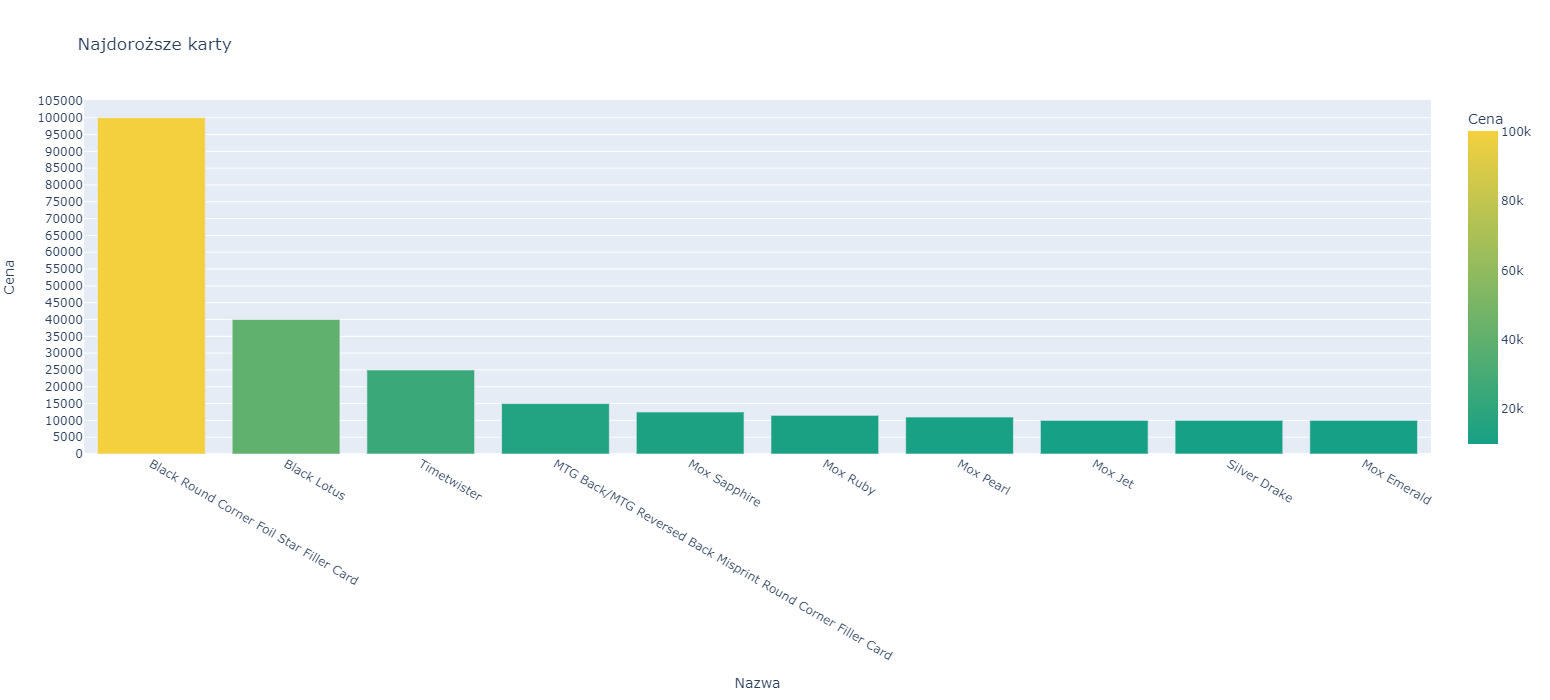

In [17]:
colorGradient=["#16A085", "#F4D03F"]

df_valuable = df.copy()
df_valuable = df_valuable.sort_values(by=['price'], ascending=False)
df_valuable = df_valuable.head(10)

fig = px.bar(df_valuable, x='name', y='price', width=1100, height=700, title="Najdoroższe karty", color="price", color_continuous_scale=colorGradient, labels={
                     "name": "Nazwa",
                     "price": "Cena"
                 })
fig.update_yaxes(tick0=0, dtick=5000, tickformat = "digit")

fig.show()

### 10 najdroższych rozszerzeń

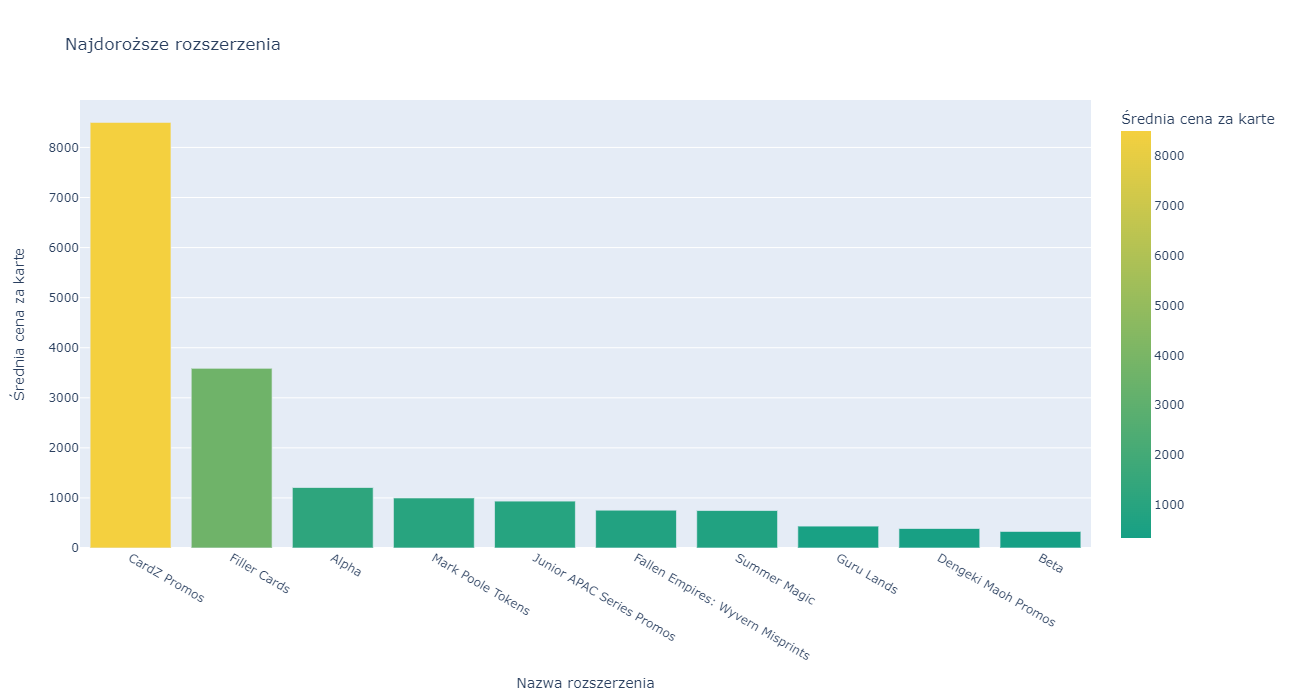

In [9]:
df_exp_means = df.groupby('expansion')['price'].mean()
df_exp_means = df_exp_means.sort_values(ascending=False)
df_exp_means = df_exp_means.to_frame()
df_exp_means = df_exp_means.head(10)
fig = px.bar(df_exp_means, y='price', width=1000, height=700, title="Najdoroższe rozszerzenia", color="price", color_continuous_scale=colorGradient, labels={
                     "expansion": "Nazwa rozszerzenia",
                     "price": "Średnia cena za karte"
                 })
fig.update_yaxes(tick0=0, dtick=1000, tickformat = "digit")

### Procentowy udział różnych rzadkości

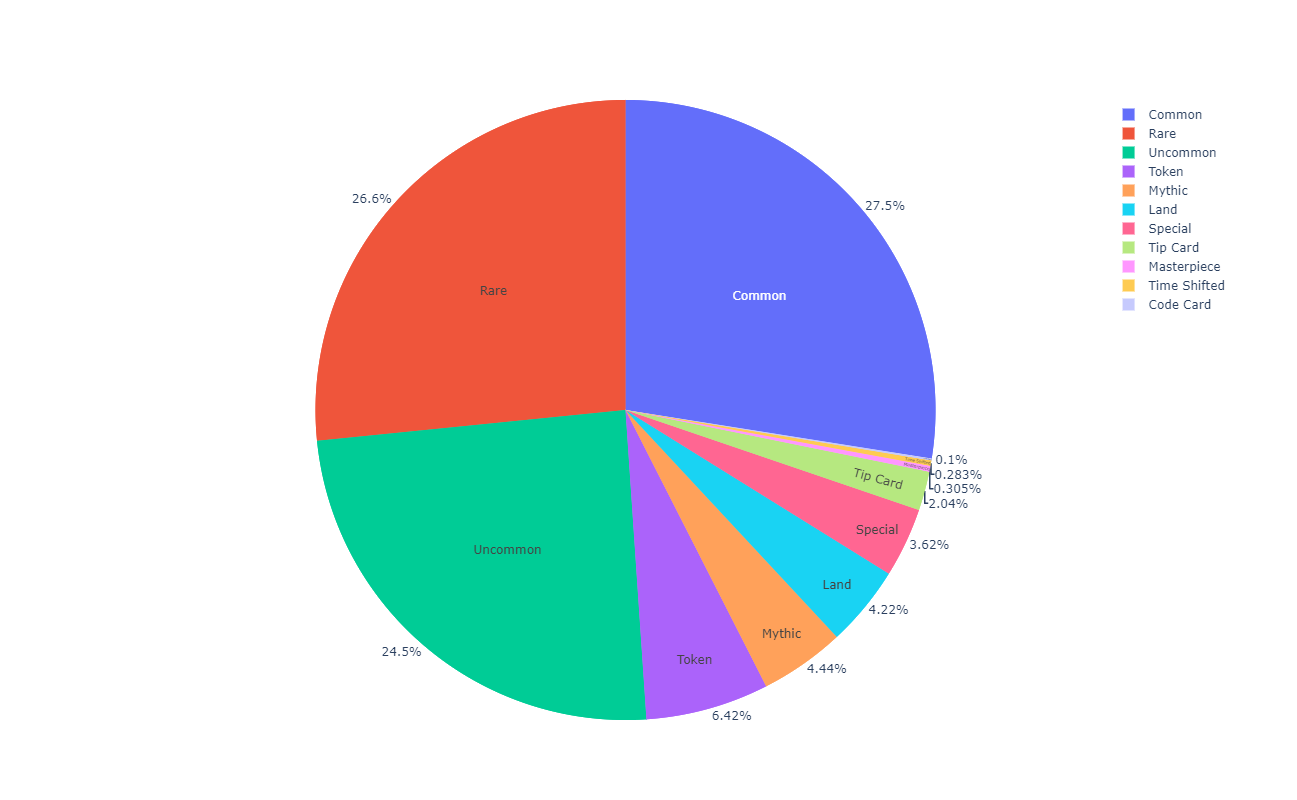

In [10]:
df_rarity = df.groupby(['rarity']).size()
df_rarity = df_rarity.sort_values(ascending=False)

common_props = dict(labels=df_rarity.keys(),
                    values=df_rarity.values,)
trace1 = go.Pie(**common_props, textinfo='percent', textposition='outside')
trace2 = go.Pie( **common_props, textinfo='label', textposition='inside')


fig = go.Figure(data=[trace1, trace2])
fig.update_layout(width=800, height=800)
fig.show()

### Największe różnice w cenie między kartą foliowaną a zwykłą

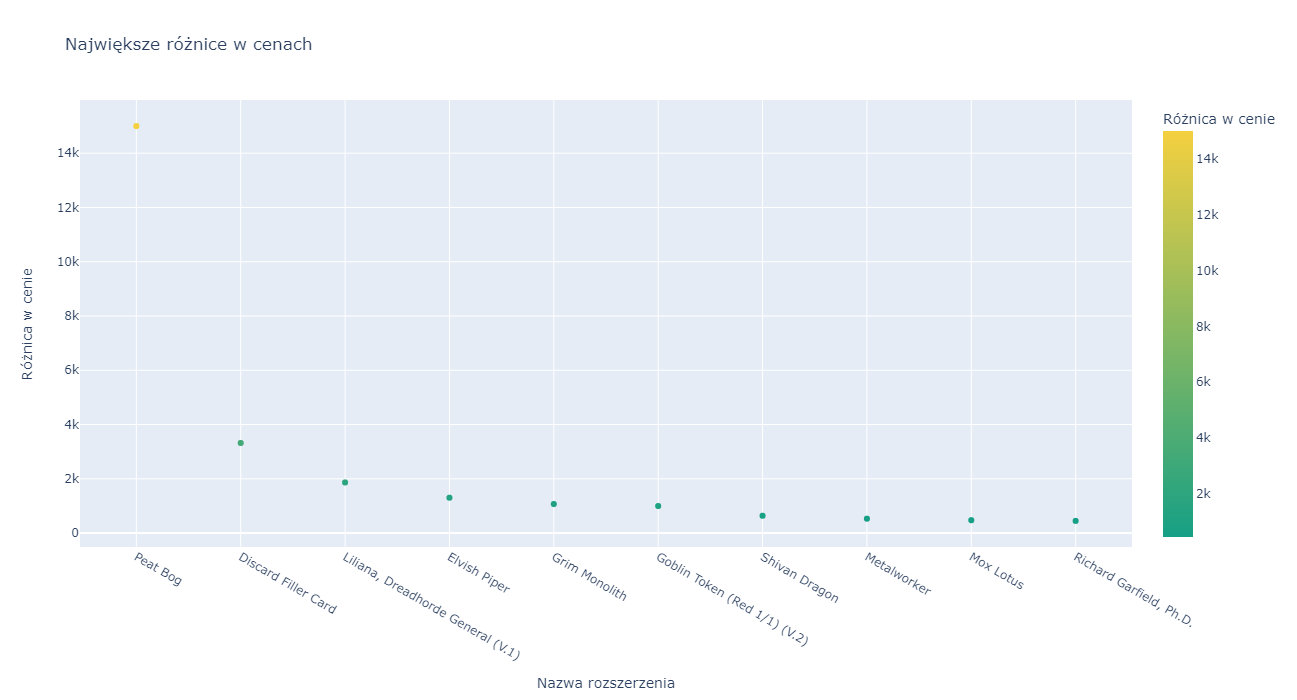

In [14]:
df_difference = df.copy()
df_difference['priceDif'] = df_difference['priceFoil'] - df_difference['price']
df_difference = df_difference.sort_values(by=['priceDif'], ascending=False)
df_difference = df_difference.head(10)

fig = px.scatter(df_difference, x='name', y='priceDif', width=1000, height=700, title="Największe różnice w cenach", color="priceDif", color_continuous_scale=colorGradient, labels={
                     "name": "Nazwa rozszerzenia",
                     "priceDif": "Różnica w cenie"
                 })
fig.show()

### Karty posiadające największą ilość wydań

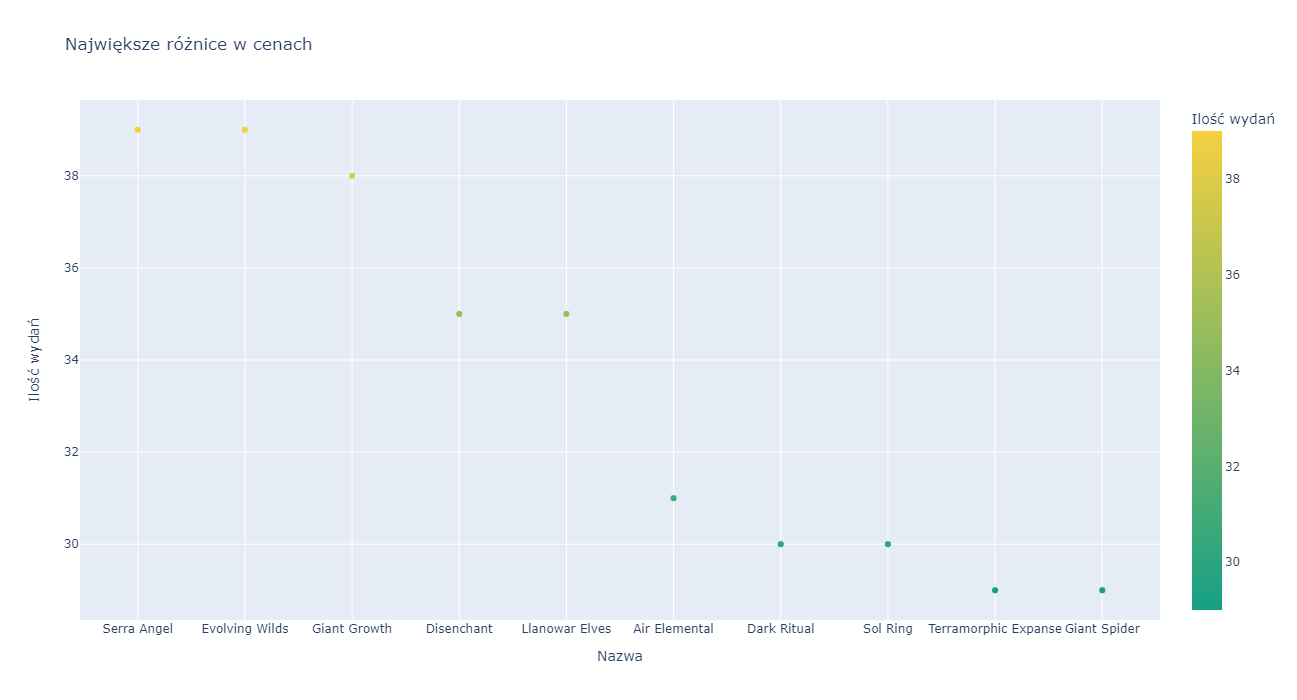

In [12]:
df_cardExs = df.copy()
df_cardExs = df_cardExs[df_cardExs['rarity']!='Land']
df_cardExs = df_cardExs[df_cardExs['rarity']!='Special']
df_cardExs = df_cardExs[df_cardExs['rarity']!='Token']
#df_cardExs[df_cardExs['name']=='Forest (V.2)']
df_cardExs = df_cardExs.groupby('name')['expansion'].size()
df_cardExs = df_cardExs.sort_values(ascending=False)
df_cardExs = df_cardExs.head(10)
df_cardExs = df_cardExs.to_frame()
fig = px.scatter(df_cardExs, y='expansion', width=1000, height=700, title="Największe różnice w cenach", color="expansion", color_continuous_scale=colorGradient, labels={
                     "expansion": "Ilość wydań",
                     "name": "Nazwa"
                 })
fig.show()

### Histogram cen

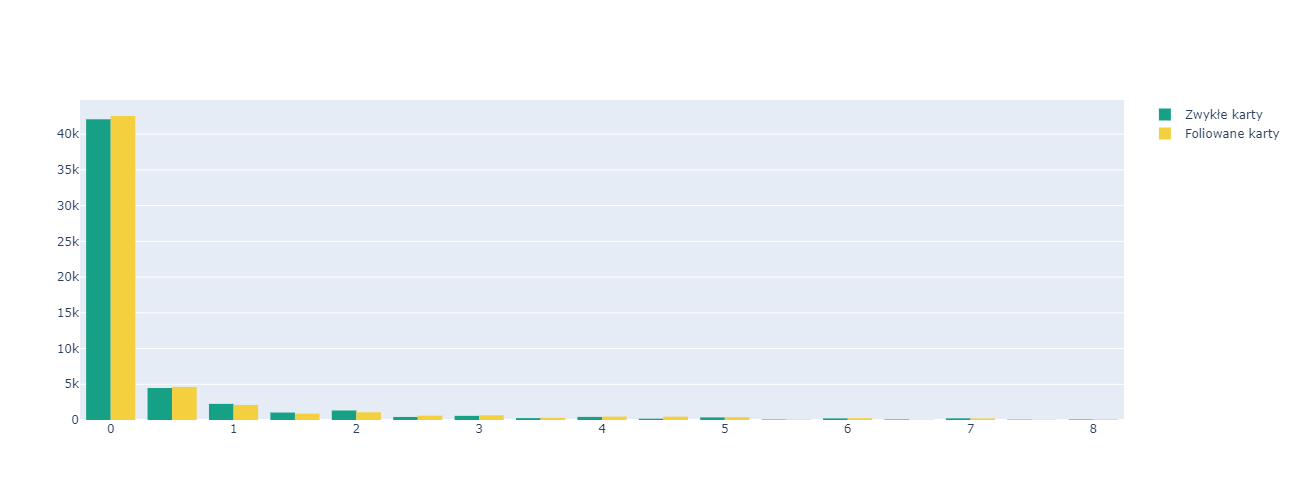

In [13]:
df_pricehist = df[df.price<8]
df_priceFoil = df[df.priceFoil<8]
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_pricehist.price, nbinsx=20, marker_color='#16A085', name='Zwykłe karty'))
fig.add_trace(go.Histogram(x=df_priceFoil.priceFoil, nbinsx=20, marker_color='#F4D03F', name='Foliowane karty'))
fig.update_layout(width=800, height=500)


fig.show()